<a href="https://colab.research.google.com/github/chlolv/NLP_Project/blob/main/1_Stat_desc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Package and definitions


In [1]:
import requests as req
import pandas as pd
import os
import re
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from termcolor import colored
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
try :
  import transformers
except :
  !pip install transformers
  import transformers
from transformers import AutoModel, BertTokenizerFast
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW
from sklearn.utils.class_weight import compute_class_weight
from nltk.tokenize import sent_tokenize
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from itertools import compress
import seaborn as sns
from tqdm import *
import time

# torch.cuda.is_available() returns a boolean to check if the GPU can be used or not
if torch.cuda.is_available():
  # if CUDA is available set 'cuda' as the device
  device = 'cuda'
  # and then print the name of the GPU
  print('DEVICE = ', colored(torch.cuda.get_device_name(0), "green" ) )
else:
  # else, set 'cpu' as device
  device = 'cpu'
  # just print than the CPU is used. Alternatively you can check your CPU with the following command (linux based) in the next cell:
  # ! lscpu
  print('DEVICE = ', colored('CPU', "blue"))

git_url = "https://raw.githubusercontent.com/chlolv/NLP_Project/main/Data/"
H_url = "H_series.csv"
book_url = "book_labels.csv"

# temp fixes due to csv use
H = req.get(git_url + H_url)
H = re.sub('\n\d{0,9}[0-9],',
           '\n', H.text[7:])
words = ["He-", "\\\\", '"', '"', "o-"]
H = re.sub("".join(words), "He-Who", H)
H = re.sub("\*", "" , H)
H = H.split('\n')

book = req.get(git_url + book_url)
book_label_list = re.sub('','0', book.text[6:])
book_label_list = re.sub('010','1', book_label_list)
book_label_list = re.sub('020','2', book_label_list)
book_label_list = re.sub('030','3', book_label_list)
book_label_list = re.sub('040','4', book_label_list)
book_label_list = re.sub('050','5', book_label_list)
book_label_list = re.sub('060','6', book_label_list)
book_label_list = re.sub('070','7', book_label_list)
book_label_list = book_label_list.split('\n')

book_label_list = [int(book) for book in book_label_list]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
DEVICE =  Tesla K80


In [2]:
len_book = []
mean_book = []
med_book = []
std_book = []

for book in range(1,8) :
    BOOL = [book_label == book for book_label in book_label_list]
    H_subset = list(compress(H, BOOL))  
    len_list = []
    
    for paragraph in H_subset :
        len_list.append(len(paragraph.split()))
    len_book.append(len(len_list))
    mean_book.append(np.mean(len_list))
    med_book.append(np.median(len_list))
    std_book.append(np.std(len_list))

In [3]:
desc_len_para = pd.DataFrame(data = [len_book, mean_book, med_book, std_book], 
                    index = ["Nb_para", "Avg_len_para", "Med_len_para", "Std_len_para"],
                    columns = ["HP_1", "HP_2", "HP_3", "HP_4", "HP_5", "HP_6", "HP_7"])

In [4]:
desc_len_para.T

,Nb_para,Avg_len_para,Med_len_para,Std_len_para
HP_1,1451.0,53.864921,46.0,25.279002
HP_2,2140.0,40.470561,37.0,10.559293
HP_3,2109.0,49.890469,44.0,20.172322
HP_4,3600.0,54.313889,47.0,25.074906
HP_5,5115.0,50.658065,44.0,21.625114
HP_6,3134.0,55.235163,47.0,25.423055
HP_7,3380.0,59.181065,47.0,49.562366


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

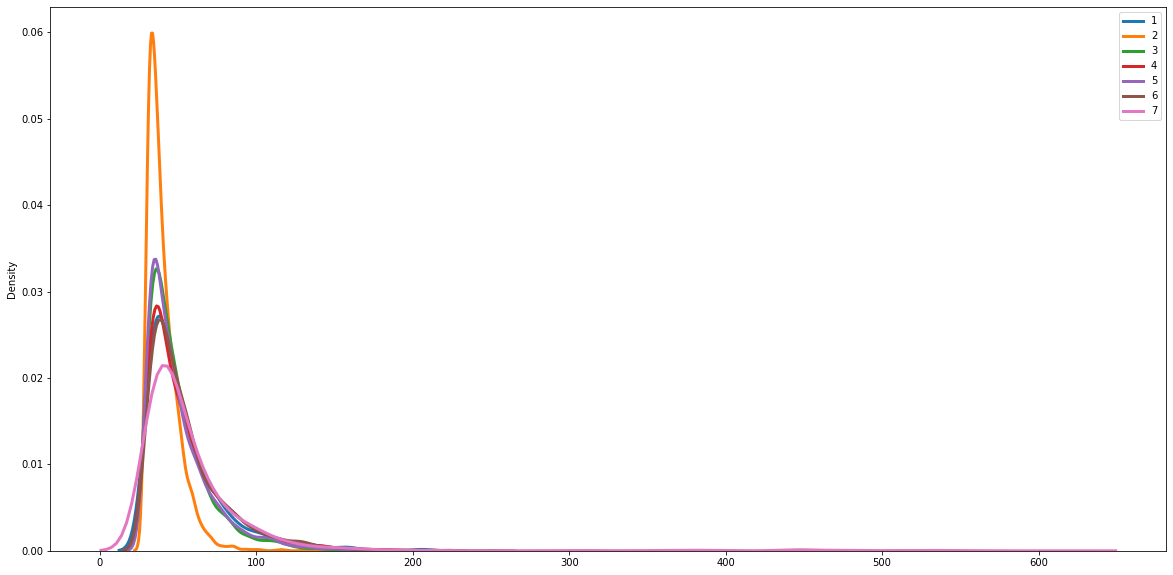

In [5]:
plt.rcParams['figure.figsize'] = [20, 10]

for book in range(1,8) :
  BOOL = [book_label == book for book_label in book_label_list]
  H_subset = list(compress(H, BOOL))  
  len_list = []
  for paragraph in H_subset :
    len_list.append(len(paragraph.split()))
    
  sns.distplot(len_list, hist = False, kde = True,
                kde_kws = {'linewidth': 3},
                label = book)
plt.legend()
plt.show()

# Basic analysis


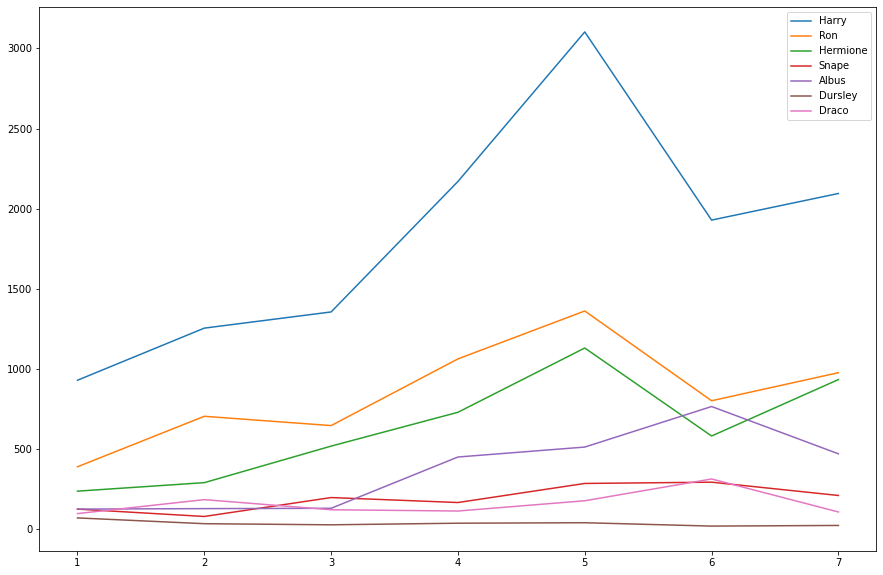

In [6]:
character_list = [['Harry', 'Potter'], ['Ron', 'Weasley'], ['Hermione', 'Granger'], ['Snape', 'Severus'], ['Albus', 'Dumbledore'], ['Dursley'], ['Draco', 'Malfoy']]
count_dict = {}
key = 0
for book in range(1,8) :
  BOOL = [book_label == book for book_label in book_label_list]
  H_subset = list(compress(H, BOOL))
  for character in character_list :
    count = 0
    for paragraph in H_subset :
      if any(name in paragraph for name in character) :
        count += 1
    new_key = {'book' : book, 'character' : character[0], 'count' : count}
    count_dict[str(key)] = new_key
    key += 1
count_data = pd.DataFrame(count_dict).T

plt.rcParams['figure.figsize'] = [15, 10]
for character in character_list :
  x = count_data[count_data['character'] == character[0]]['book']
  y = count_data[count_data['character'] == character[0]]['count']
  plt.plot(x, y, label = character[0])
plt.legend()
plt.show()


# Further processing for training

In [7]:
for i in range(0, len(H)) :
  H[i] = re.sub("[!?]", '.', H[i])
  H[i] = H[i].replace("...", '.')
  H[i] = re.sub('[,\\-"()]', ' ', H[i])
  H[i] = re.sub('\*', '', H[i]) 
  H[i] = re.sub('\\\\', '', H[i]) 
vocabulary = []
for i in range(0, len(H)) :
  element = re.sub("[.]", ' ', H[i])
  words = element.split()
  vocabulary.append(words)
vocabulary = [item for sublist in vocabulary for item in sublist]
voc_count = Counter(vocabulary)
voc_count = pd.DataFrame.from_dict(voc_count, orient = 'index').sort_values(by = [0], ascending = [False])

total_ranking = voc_count[0:10]

In [8]:
 len_indices = list(np.cumsum(len_book))
 len_indices.insert(0, 0)
 
for j in range(7):
  for i in range(len_indices[j], len_indices[j+1]) :
    H[i] = re.sub("[!?]", '.', H[i])
    H[i] = H[i].replace("...", '.')
    H[i] = re.sub('[,\\-"()]', ' ', H[i])
    H[i] = re.sub('\*', '', H[i]) 
    H[i] = re.sub('\\\\', '', H[i]) 
  vocabulary = []
  for i in range(len_indices[j], len_indices[j+1]) :
    element = re.sub("[.]", ' ', H[i])
    words = element.split()
    vocabulary.append(words)
  vocabulary = [item for sublist in vocabulary for item in sublist]
  voc_count = Counter(vocabulary)
  voc_count = pd.DataFrame.from_dict(voc_count, orient = 'index').sort_values(by = [0], ascending = [False])
  if j == 0 :
    final_df = voc_count[0:10]
    final_df["book"] = j+1
  else :
    final_df_bis = voc_count[0:10]
    final_df_bis["book"] = j+1
    final_df = pd.concat([final_df, final_df_bis], axis = 0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [9]:
final_df['word'] = final_df.index
final_df.rename(columns = {0: "count"})

,count,book,word
the,3309,1,the
to,1844,1,to
and,1807,1,and
a,1580,1,a
of,1248,1,of
...,...,...,...
he,2907,7,he
Harry,2871,7,Harry
was,2744,7,was
his,2493,7,his
